# Exploring locations for street-closures to promote social distancing during the COVID-19 pandemic using open-source bike share trip data.

#### Steps:
* density of bike share stations in East Bay
    * gif with change over time?
    * heatmap of ridership times and dates?
* put O-Ds (unique) though OSMnx route to get most used routes (Feb 2020 only?)
* use to inform locaitons hwere street closures would be useful to encourage social distancing
    * overlay with bike boulevards and lanes
    * overlay with bus routes
    * overlay with SAFETrec bike crash locations?
    
**Alternate title:** Using open-source bike share trip data to inform social distancing street closures.

#### Articles:
* [Mapping how cities are reclaiming street space](https://ny.curbed.com/2020/4/6/21209462/nyc-car-free-streets-coronavirus-bill-de-blasio)
* [How to open streets right during social distancing](https://usa.streetsblog.org/2020/04/08/how-to-open-streets-right-during-social-distancing/#new_tab)
* [NYC car-free streets pilot cut short](https://ny.curbed.com/2020/4/6/21209462/nyc-car-free-streets-coronavirus-bill-de-blasio)
* [Oakland closing 74 miles of streets](https://sf.streetsblog.org/2020/04/10/oakland-to-open-74-miles-of-streets-for-safe-biking-and-recreation/)

## Initialize

In [1]:
import csv
import json
import geojson
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

In [2]:
# gbfs_stations = r'https://gbfs.baywheels.com/gbfs/en/station_information.json'
# gbfs_regions = r'https://gbfs.baywheels.com/gbfs/en/system_regions.json'

In [3]:
# def is_number(s):
#     try:
#         float(s)
#         return True
#     except ValueError:
#         return False

## Load Data

In [4]:
# load raw data
trips = pd.read_csv("../data/202002-baywheels-tripdata.csv", low_memory=False)

## Heatmap
* http://seaborn.pydata.org/examples/heatmap_annotation.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html


* mess of code for [creating animations](https://stackoverflow.com/questions/46236902/redrawing-seaborn-figures-for-animations) in matplotlib
* simpler [animation](https://python-graph-gallery.com/340-scatterplot-animation/) in seaborn using gifs

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
# truncate data to be list of trip counts by day of week (0-6) and hour of day (0-23)
trips['start_time'] = pd.to_datetime(trips.start_time, format='%Y-%m-%d %H:%M:%S.%f')
trips['day'] = trips['start_time'].dt.weekday
trips['hour'] = trips['start_time'].dt.hour
heatmap_df = trips.groupby(['day', 'hour']).start_time.count().reset_index()
heatmap_df.rename(columns={"start_time": "count"}, inplace=True)

In [7]:
# convert to long-form and rename index
heatmap_df = heatmap_df.pivot("day", "hour", "count")
heatmap_df.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
heatmap_df.index.name = 'day'

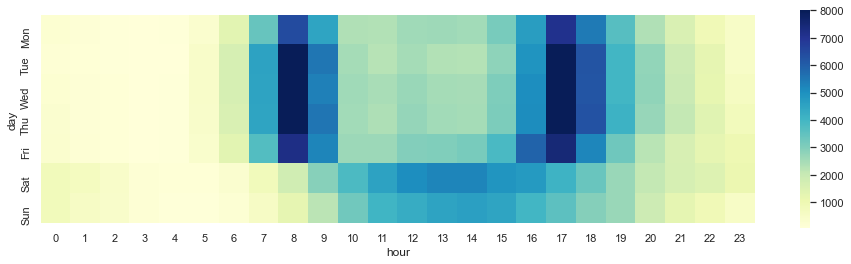

In [8]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 4))
sns.heatmap(heatmap_df, 
            cmap="YlGnBu", 
            square=True, 
            vmax=8000,
            ax=ax)

## Get unique OD pairs from trip table

In [9]:
# group trips by Origin-Destination pair
trips_agg = trips.groupby(["start_station_id", "end_station_id"]).agg({'start_time':'count',
                                                                      'start_station_latitude': 'first',
                                                                      'start_station_longitude': 'first',
                                                                      'end_station_latitude': 'first',
                                                                      'end_station_longitude': 'first'})
trips_agg.reset_index(inplace=True)
trips_agg.rename(columns={"start_time": "count"}, inplace=True)
trips_agg = trips_agg.loc[trips_agg.start_station_id != trips_agg.end_station_id]
trips_agg.head()

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
1,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915
2,3.0,5.0,27,37.786375,-122.404904,37.783899,-122.408445
3,3.0,6.0,13,37.786375,-122.404904,37.804770,-122.403234
4,3.0,8.0,6,37.786375,-122.404904,37.799953,-122.398525
5,3.0,9.0,3,37.786375,-122.404904,37.798572,-122.400869


## Get unique stations from trip table

In [11]:
# subset data for only origins and relevant columns
trips_start = trips[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']]
trips_start.columns = ['station_id', 'name', 'lat', 'lon']

# subset data for only destinations and relevant columns
trips_end = trips[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]
trips_end.columns = ['station_id', 'name', 'lat', 'lon']

# join origins and destinations, filter to only include unique/non-null values
stations = trips_start.append(trips_end)
stations.dropna(inplace=True)
stations.drop_duplicates(inplace=True)

# turn data into geospatial dataframe
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))

# view gdf
stations.head()

,station_id,name,lat,lon,geometry
0,176.0,MacArthur BART Station,37.828410,-122.266315,POINT (-122.26631 37.82841)
1,375.0,Grove St at Masonic Ave,37.774836,-122.446546,POINT (-122.44655 37.77484)
3,179.0,Telegraph Ave at 27th St,37.816073,-122.267886,POINT (-122.26789 37.81607)
5,182.0,19th Street BART Station,37.809369,-122.267951,POINT (-122.26795 37.80937)
6,252.0,Channing Way at Shattuck Ave,37.865847,-122.267443,POINT (-122.26744 37.86585)


## Label stations by regions 
Using self-defined bounding boxes

In [12]:
from shapely.geometry import Polygon

In [13]:
# define a bounding boxes for bike share regions
regions = [{"name": "East Bay", "lat": [37.9, 37.9, 37.76, 37.76, 37.9], 
                                "lon": [-122.2, -122.32, -122.32, -122.2, -122.2]},
           {"name": "San Francisco", "lat": [37.81, 37.81, 37.71, 37.71, 37.81], 
                                     "lon": [-122.37, -122.48, -122.48, -122.37, -122.37]},
           {"name": "San Jose", "lat": [37.375, 37.375, 37.305, 37.305, 37.375], 
                                "lon": [-121.86, -121.925, -121.925, -121.86, -121.86]}]

# create empty gdf to store data
crs = 'epsg:4326'
bbox_gdf = gpd.GeoDataFrame(columns=["region", "geometry"], crs=crs)

# loop through regions, create bounding boxes for each one
for i in range(len(regions)):
    polygon_geom = Polygon(zip(regions[i]['lon'], regions[i]['lat']))
    bbox_gdf = bbox_gdf.append({'region': regions[i]['name'], 'geometry': polygon_geom}, ignore_index=True)

In [14]:
# # add regions to stations
# for index, row in bbox_gdf.iterrows():
#     stations[row['region']] = stations.within(bbox_gdf.loc[index, 'geometry'])

# # see new table
# stations.head()

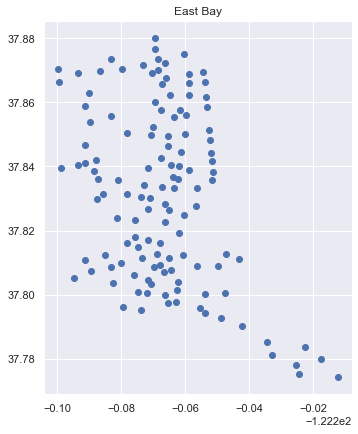

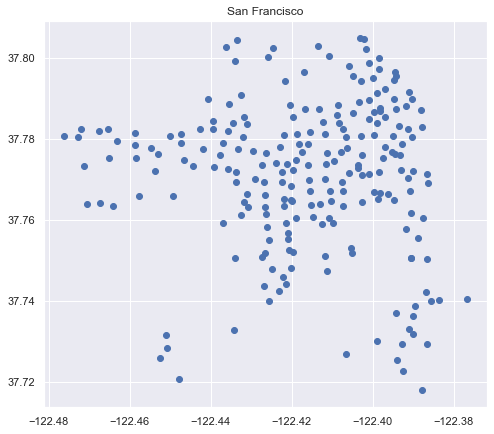

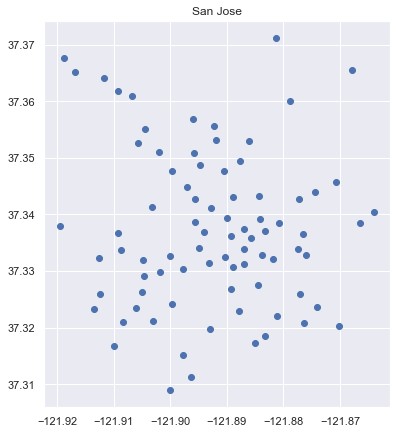

In [16]:
# map all three regions
# for i in range(len(regions)):
for index, row in bbox_gdf.iterrows():
    fig, ax = plt.subplots(figsize = (9,6))
    # stations.loc[trips_gdf[regions[i]['name']]==True].plot(ax=ax)
    stations.loc[stations.within(bbox_gdf.loc[index, 'geometry'])].plot(ax=ax)

    plt.tight_layout()
    # plt.title(regions[i]['name'])
    plt.title(row['region'])
    plt.show()

In [17]:
# create gdfs of only stations in the East Bay
# stations_eb = stations.loc[stations['East Bay']==True].copy()

# # create gdfs of only stations in San Francisco
# stations_sf = stations.loc[stations['San Francisco']==True].copy()

# # create gdfs of only stations in San Jose
# stations_sj = stations.loc[stations['San Jose']==True].copy()

In [18]:
# select only trips in the East Bay
# trips_eb = trips_agg[(trips_agg.start_station_id.isin(stations_eb.station_id)) & 
#                      (trips_agg.end_station_id.isin(stations_eb.station_id))]

# # select only trips in San Francisco
# trips_sf = trips_agg[(trips_agg.start_station_id.isin(stations_sf.station_id)) & 
#                      (trips_agg.end_station_id.isin(stations_sf.station_id))]

# # select only trips in San Jose
# trips_sj = trips_agg[(trips_agg.start_station_id.isin(stations_sj.station_id)) & 
#                      (trips_agg.end_station_id.isin(stations_sj.station_id))]

In [19]:
# trips_agg = trips_agg.merge(trips_gdf[['station_id', 'lat', 'lon']], 
#                             left_on="start_station_id", 
#                             right_on="station_id")
# trips_agg.drop(columns=['station_id'], inplace=True)
# trips_agg.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'}, inplace=True)

# trips_agg = trips_agg.merge(trips_gdf[['station_id', 'lat', 'lon']], 
#                             left_on="end_station_id", 
#                             right_on="station_id")
# trips_agg.drop(columns=['station_id'], inplace=True)
# trips_agg.rename(columns={'lat': 'end_lat', 'lon': 'end_lon'}, inplace=True)

## OSMNx
* Get network for all locations around East Bay Bay Wheels (can repeat later for SF, San Jose)
* For each origin point use OSMnx to find the nearest network node
* For each destination point use OSMnx to find the nearest network node
* Calculate the shortest path between each origin/destination node pair, using nx.shortest_path
* Save the route to a MultiLineString wkt
* As the wkt is plain-text, just save this text to disk using any Python serialization method. Or assemble all the MultiLineStrings themselves into a geopandas GeoSeries and save that to disk as a shapefile or a GeoJSON file.

#### Sources:
* https://stackoverflow.com/questions/58257528/osmnx-shortest-path-for-a-set-of-origins-and-destinations
* https://stackoverflow.com/questions/46238813/osmnx-get-coordinates-of-nodes-using-osm-id

https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe
https://stackoverflow.com/questions/37428218/how-to-properly-apply-a-lambda-function-into-a-pandas-data-frame-column

In [20]:
# import OSMnx methods
import osmnx as ox
import networkx as nx
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11.4'

In [21]:
# import timing methods
import time
from tqdm import tqdm

In [22]:
# working with East Bay data first, so define region name and tables to use
# region = "East Bay"
# trips = trips_eb.copy()
# stations = stations_eb.copy()

In [23]:
# # Define a bounding box
# bounds = bbox_gdf.loc[bbox_gdf.region==region].geometry.bounds
# north, south, east, west = bounds.maxy[0], bounds.miny[0], bounds.maxx[0], bounds.minx[0]

# # Create network from that bounding box. Setting network_type='bike' because 
# # we want on- and off-road bike paths for routing.
# G = ox.graph_from_bbox(north, south, east, west, network_type='bike')

# # Do not reproject the network yet, we want it in WGS84 for routing with our (lat,lon) coordinates

# # plot network
# # fig, ax = ox.plot_graph(G)

In [24]:
# # create empty array to store nodes
# nodes_list = []

# # loop though all stations, get nearest node, append to list
# for i in tqdm(range(len(stations))):
#     node = ox.get_nearest_node(G, (trips_gdf.iloc[i]['lat'], trips_gdf.iloc[i]['lon']))
#     nodes_list.append(node)

# # add list to origin and destination nodes to the dataframe
# stations['node'] = np.array(nodes_list)

In [30]:
nodes_df = pd.DataFrame(columns=['station_id', 'ox_node', 'region'])
networks = []
for index, row in bbox_gdf.iterrows():
    r = row['region']
    i = index
    print(f"Retrieving OSMnx network within {r}")
    
    # Define a bounding box for current region
    bounds = bbox_gdf.loc[bbox_gdf.region==r].geometry.bounds
    north, south, east, west = bounds.maxy[i], bounds.miny[i], bounds.maxx[i], bounds.minx[i]
    
    # Create network from that bounding box. Setting network_type='bike' because 
    # we want on- and off-road bike paths.
    G = ox.graph_from_bbox(north, south, east, west, network_type='bike')
    networks.append(G)
    
    print(f"Collecting OSMnx node ids within {r}")
    
    # Create empty array to store nodes
    nodes_list = []
    station_ids = []
    region_name = []
    
    # select all nodes in that region
    temp_gdf = stations.loc[stations.within(bbox_gdf.loc[i, 'geometry'])].copy()

    # loop though all trips, get nearest node and append to array
    for j in tqdm(range(len(temp_gdf))):
        node = ox.get_nearest_node(G, (temp_gdf.iloc[j]['lat'], temp_gdf.iloc[j]['lon']))
        nodes_list.append(node)
        station_ids.append(temp_gdf.iloc[j]['station_id'])
        region_name.append(r)

    # create dataframe with nearest nodes
    temp_df = pd.DataFrame({'station_id': station_ids,
                            'ox_node': nodes_list,
                            'region': region_name}) 
    nodes_df = nodes_df.append(temp_df)

Retrieving OSMnx network within East Bay


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.04it/s]


Retrieving OSMnx network within San Francisco


  0%|                                                                                          | 0/226 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:23<00:00,  9.64it/s]


Retrieving OSMnx network within San Jose


  4%|███                                                                                | 3/82 [00:00<00:03, 25.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:05<00:00, 15.50it/s]


In [33]:
# merge nearest nodes df with stations gdf
stations = stations.merge(nodes_df, on="station_id", how="left")
stations.head()

In [32]:
# stations.merge(temp_df, on="station_id", how="left")

In [49]:
stations.head()

,station_id,name,lat,lon,geometry,ox_node,region
0,176.0,MacArthur BART Station,37.828410,-122.266315,POINT (-122.26631 37.82841),4096114902,East Bay
1,375.0,Grove St at Masonic Ave,37.774836,-122.446546,POINT (-122.44655 37.77484),65356407,San Francisco
2,179.0,Telegraph Ave at 27th St,37.816073,-122.267886,POINT (-122.26789 37.81607),283261632,East Bay
3,182.0,19th Street BART Station,37.809369,-122.267951,POINT (-122.26795 37.80937),2389106017,East Bay
4,252.0,Channing Way at Shattuck Ave,37.865847,-122.267443,POINT (-122.26744 37.86585),53063548,East Bay


In [40]:
print(len(stations))
print(len(stations[stations.region=="East Bay"].ox_node))
print(len(stations[stations.region=="San Francisco"].ox_node))
print(len(stations[stations.region=="San Jose"].ox_node))

438
128
228
82


In [47]:
stations.region.unique()

array(['East Bay', 'San Francisco', 'San Jose'], dtype=object)

In [48]:
trips_agg

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
1,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915
2,3.0,5.0,27,37.786375,-122.404904,37.783899,-122.408445
3,3.0,6.0,13,37.786375,-122.404904,37.804770,-122.403234
4,3.0,8.0,6,37.786375,-122.404904,37.799953,-122.398525
5,3.0,9.0,3,37.786375,-122.404904,37.798572,-122.400869
...,...,...,...,...,...,...,...
24400,512.0,6.0,1,37.789688,-122.440688,37.804770,-122.403234
24401,512.0,31.0,1,37.789688,-122.440688,37.783813,-122.434559
24402,512.0,43.0,1,37.789688,-122.440688,37.778768,-122.415929
24403,512.0,53.0,2,37.789688,-122.440688,37.775946,-122.437777


In [51]:
# add start station ox_node and region to trips df
trips_agg = trips_agg.merge(stations[['station_id', 'ox_node', 'region']], 
                            left_on="start_station_id", 
                            right_on="station_id",
                            how="left")
trips_agg.drop(columns=['station_id'], inplace=True)
trips_agg.rename(columns={'ox_node': 'start_node', 'region': 'start_region'}, inplace=True)

# add end station ox_node and region to trips df
trips_agg = trips_agg.merge(stations[['station_id', 'ox_node', 'region']], 
                            left_on="end_station_id", 
                            right_on="station_id")
trips_agg.drop(columns=['station_id'], inplace=True)
trips_agg.rename(columns={'ox_node': 'end_node', 'region': 'end_region'}, inplace=True)

In [52]:
trips_agg.head()

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_node,start_region,end_node,end_region
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,San Francisco,65313138,San Francisco
1,5.0,4.0,2,37.783899,-122.408445,37.785881,-122.408915,1723739163,San Francisco,65313138,San Francisco
2,6.0,4.0,2,37.804770,-122.403234,37.785881,-122.408915,33241803,San Francisco,65313138,San Francisco
3,10.0,4.0,1,37.795393,-122.404770,37.785881,-122.408915,65374771,San Francisco,65313138,San Francisco
4,11.0,4.0,3,37.797280,-122.398436,37.785881,-122.408915,65328969,San Francisco,65313138,San Francisco


In [58]:
# Drop all trips that don't start and end in the same region. This could happen only if
# the bike rider took the bike on transit or in a car to another region...even if they did manage
# to bike from Oakland to San Jose it is not useful for this analysis.
trips_agg = trips_agg.loc[trips_agg.start_region==trips_agg.end_region].copy()

In [63]:
# create variables for each network
G0, G1, G2 = [x for x in networks]
del networks

# fig, ax = ox.plot_graph(nx.compose(G0, G1))

In [68]:
from shapely.geometry import LineString, Point

In [70]:
g0_nodes, g0_edges = ox.graph_to_gdfs(G0)
g1_nodes, g1_edges = ox.graph_to_gdfs(G1)
g2_nodes, g2_edges = ox.graph_to_gdfs(G2)

In [71]:
paths = []
lines = []

for i in tqdm(range(len(trips_agg))):
    origin_node = trips_agg.iloc[i]['start_node']
    destination_node = trips_agg.iloc[i]['end_node']
    region = trips_agg.iloc[i]['start_region']
    if region == "East Bay":
        route = nx.shortest_path(G0, origin_node, destination_node)
        route_nodes = g0_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    elif region == "San Francisco":
        route = nx.shortest_path(G1, origin_node, destination_node)
        route_nodes = g1_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    elif region == "San Jose":
        route = nx.shortest_path(G2, origin_node, destination_node)
        route_nodes = g2_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    else:
        route = np.nan
        route_line = np.nan
    paths.append(route)
    lines.append(route_line)

# paths_df = pd.DataFrame({''})
trips_agg['route'] = np.array(paths)
trips_gdf = gpd.GeoDataFrame(trips_agg, crs=crs, geometry=lines)

100%|████████████████████████████████████████████████████████████████████████████| 24154/24154 [09:52<00:00, 40.78it/s]


TypeError: float() argument must be a string or a number, not 'LineString'

In [76]:
trips_gdf.head()

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_node,start_region,end_node,end_region,route,geometry
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,San Francisco,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37..."
1,5.0,4.0,2,37.783899,-122.408445,37.785881,-122.408915,1723739163,San Francisco,65313138,San Francisco,"[1723739163, 65313131, 65313133, 65313138]","LINESTRING (-122.40807 37.78401, -122.40853 37..."
2,6.0,4.0,2,37.804770,-122.403234,37.785881,-122.408915,33241803,San Francisco,65313138,San Francisco,"[33241803, 260194262, 280836272, 6250503702, 2...","LINESTRING (-122.40345 37.80504, -122.40228 37..."
3,10.0,4.0,1,37.795393,-122.404770,37.785881,-122.408915,65374771,San Francisco,65313138,San Francisco,"[65374771, 4039511684, 65337586, 65336155, 653...","LINESTRING (-122.40497 37.79533, -122.40565 37..."
4,11.0,4.0,3,37.797280,-122.398436,37.785881,-122.408915,65328969,San Francisco,65313138,San Francisco,"[65328969, 65372268, 65336941, 65307352, 65307...","LINESTRING (-122.39835 37.79709, -122.39819 37..."


In [81]:
# save to file
trips_gdf.drop(columns=['route']).to_file(driver='GeoJSON', filename="../data/BayWheels_Routes_OSMnx.geojson")

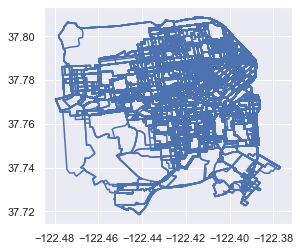

In [82]:
# plot routes
trips_gdf.loc[trips_gdf.start_region=="San Francisco"].plot()

## Testing below:

In [83]:
# trips_eb.head()
# ox.get_nearest_node(G, (trips_eb.iloc[100]['start_station_latitude'], trips_eb.iloc[100]['start_station_longitude']), )

In [85]:
# trips_eb.iloc[0]['start_station_latitude'], trips_eb.iloc[0]['start_station_longitude']

In [84]:
# trips_eb['origin_node'] = trips_eb.apply(lambda x: ox.get_nearest_node(G, (x.start_station_latitude, x.start_station_longitude)))

In [53]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.868666, -122.259166) # Bancroft and Telegraph
destination_point = (37.851554, -122.252280) # College and Alcatraz
origin_node = ox.get_nearest_node(G0, origin_point)
destination_node = ox.get_nearest_node(G0, destination_point)
origin_node, destination_node

(53080628, 5486906949)

In [55]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G0, origin_node, destination_node, weight='length')
str(route)

'[53080628, 394220748, 53006324, 53103804, 53063553, 53041092, 4621435721, 53020976, 275804265, 53082748, 53085618, 53079150, 53111890, 53099277, 5060958939, 53070407, 53103280, 56837383, 53100516, 53037921, 53082594, 53100520, 53100523, 53090686, 3245435930, 3245435929, 53070069, 53090689, 5486906949]'

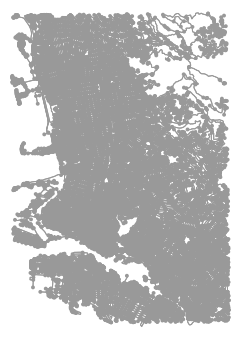

In [95]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G1, route, origin_point=origin_point, destination_point=destination_point)

In [88]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='bike')

In [89]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(65343969, 65290756)

In [90]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[65343969, 65307397, 65295324, 65295320, 65295314, 7332987498, 7332987493, 6319217963, 6319217961, 6319217960, 65319944, 6319217971, 65290756]'

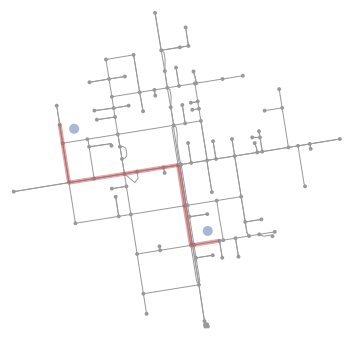

In [91]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## How to save to .html file...don't delete yet

In [103]:
from IPython.display import IFrame

In [167]:
# download the street network for Piedmont, CA
G = ox.graph_from_place('Berkeley, California, USA', network_type='bike', retain_all='False', simplify=True)

In [164]:
G?

In [129]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [130]:
# save as html file then display map as an iframe
filepath = '../data/graph.html'
graph_map.save(filepath)
# IFrame(filepath, width=600, height=500)

In [220]:
# use networkx to calculate the shortest path between two nodes
origin_point = (37.868719, -122.259174)
origin_node = ox.get_nearest_node(G, origin_point)
destination_point = (37.851623, -122.252217)
destination_node = ox.get_nearest_node(G, destination_point)
# origin_node = list(G.nodes())[0]
# destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node, weight="length")

In [221]:
print(origin_point, destination_point)
print(origin_node, destination_node)
print(route)

(37.868719, -122.259174) (37.851623, -122.252217)
53080628 5486906949
[53080628, 53099275, 53063555, 53041093, 53020977, 53020979, 4631429373, 5484497299, 53070406, 53070407, 2415284475, 56837380, 4551722985, 53037916, 53037919, 53082593, 53103284, 283272945, 283272947, 53100523, 53099164, 53090689, 5486906949]


In [222]:
# plot the route with folium
# route_map = ox.plot_route_folium(G, route)

# plot the route with folium on top of the previously created graph_map
route_graph_map = ox.plot_route_folium(G, route, route_map=graph_map, popup_attribute='length')

In [223]:
# save as html file then display map as an iframe
filepath = '../data/route_graph.html'
route_graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [214]:
point2 = (37.790495, -122.408353)
point2 = (37.888433, -122.272654)
ox.get_nearest_node(G, point2, return_dist=True)

(348192780, 0.04533549020388037)

LINESTRING (-122.2591864 37.8687053, -122.2590046 37.8678138, -122.258817 37.8669135, -122.2586383 37.8660287, -122.2584543 37.8651268, -122.2578102 37.8652096, -122.2577527 37.8646457, -122.257711 37.8642071, -122.2576343 37.8633691, -122.2574514 37.861562, -122.2573647 37.8615673, -122.2570972 37.8604184, -122.257095 37.860393, -122.2570407 37.8597622, -122.2558087 37.859843, -122.2556922 37.8581643, -122.2555109 37.8567252, -122.2550331 37.8558607, -122.2549659 37.8558232, -122.2540224 37.855943, -122.2537792 37.8537702, -122.2527488 37.8539022, -122.2525226 37.851636)


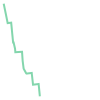

In [228]:
# https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
from shapely.geometry import LineString, Point

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
# path = nx.shortest_path(G, list(G.nodes())[0], list(G.nodes())[1])
route_nodes = gdf_nodes.loc[route]

route_line = LineString(list(route_nodes.geometry.values))
print(route_line)
route_line

# DONT DELETE CELL THIS MAY BE USEFUL!

In [218]:
print(gdf_nodes.y.min(), gdf_nodes.y.max())
print(gdf_nodes.x.min(), gdf_nodes.x.max())

37.8463312 37.9046164
-122.3195267 -122.2359026
